In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                           username = "root",
                           password = "shaem@CHB0B30",
                           database = "ecommerce" )
cur = db.cursor()

# Basic Queries

# 1. List all unique cities where customers are located.

In [35]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_city"])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [8]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total Orders placed in 2017 are", data[0][0]

('Total Orders placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [36]:
query = """ select upper(products.product_category) category, 
            round(sum(payments.payment_value),2) sales
            from products join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df.head()

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# 4. Calculate the percentage of orders that were paid in installments.

In [21]:
query = """ select (sum(case when payment_installments >= 1 then 1
                            else 0
                       end))/count(*)*100
            from payments
        """

cur.execute(query)

data = cur.fetchall()
"The percentage of orders that were paid in installments is ", data[0][0]

('The percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

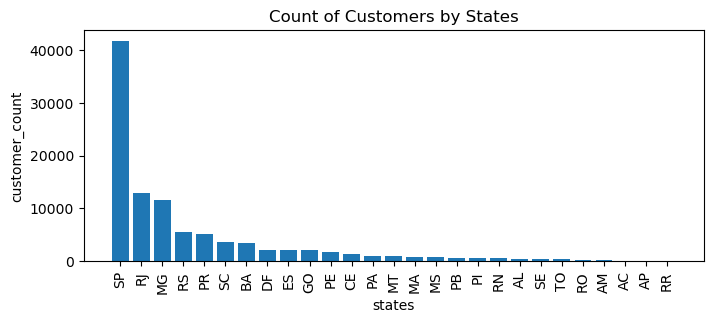

,state,customer_count
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045


In [52]:
query = """ select customer_state, count(customer_id)
            from customers 
            group by customer_state
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()
df.head()

# Intermediate Queries

# 1. Calculate the number of orders per month in 2018.

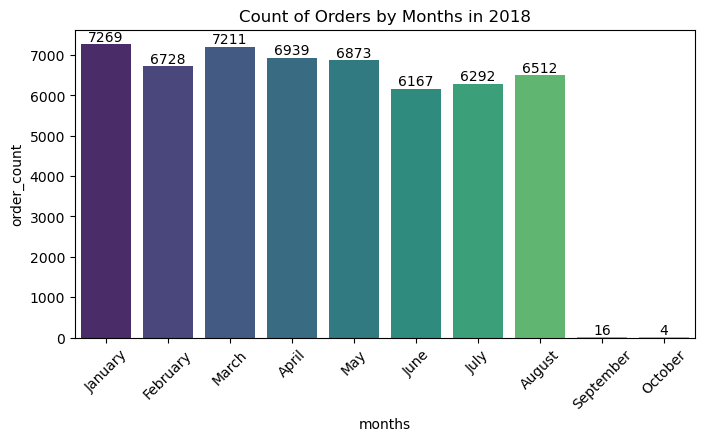

In [69]:
query = """ select monthname(order_purchase_timestamp) as months, count(order_id) order_count
            from orders
            where year(order_purchase_timestamp) = 2018
            group by months
            order by months
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","order_count"])
plt.figure(figsize = (8,4))
o = ['January','February','March','April','May','June','July','August','September','October']
# ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o)
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, palette = "viridis")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [82]:
query = """ WITH count_per_order AS 
            (SELECT 
                orders.order_id,
                orders.customer_id,
                COUNT(order_items.order_id) AS oc
            FROM
                orders
                    JOIN
                order_items ON orders.order_id = order_items.order_id
            GROUP BY orders.order_id , orders.customer_id)
            
            SELECT 
                upper(customers.customer_city),
                ROUND(AVG(count_per_order.oc), 2) average_orders
            FROM
                customers
                    JOIN
                count_per_order ON customers.customer_id = count_per_order.customer_id
            GROUP BY customers.customer_city ORDER BY average_orders desc
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,DATAS,6.00
3,CANDIDO GODOI,6.00
4,MATIAS OLIMPIO,5.00
5,MORRO DE SAO PAULO,4.00
6,TEIXEIRA SOARES,4.00
7,CURRALINHO,4.00
8,CIDELANDIA,4.00
9,PICARRA,4.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [92]:
query = """ SELECT UPPER(products.product_category) category,
            ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100, 2) sales_percentage
            FROM
            products
                JOIN
            order_items ON products.product_id = order_items.product_id
                JOIN
            payments ON payments.order_id = order_items.order_id
            GROUP BY category  
            ORDER BY sales_percentage desc
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "percentage distribution"])
df.head(10)
# plt.pie(df["percentage distribution"])
# plt.show()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [98]:
query = """ SELECT products.product_category, 
                   COUNT(order_items.product_id),
                   round(avg(order_items.price),2)
            FROM
                  products
                  JOIN
                  order_items ON products.product_id = order_items.product_id
            GROUP BY products.product_category;
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1, arr2])

print("the correlation between product price and the number of times a product has been purchased ", a[0][1])

the correlation between product price and the number of times a product has been purchased  -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

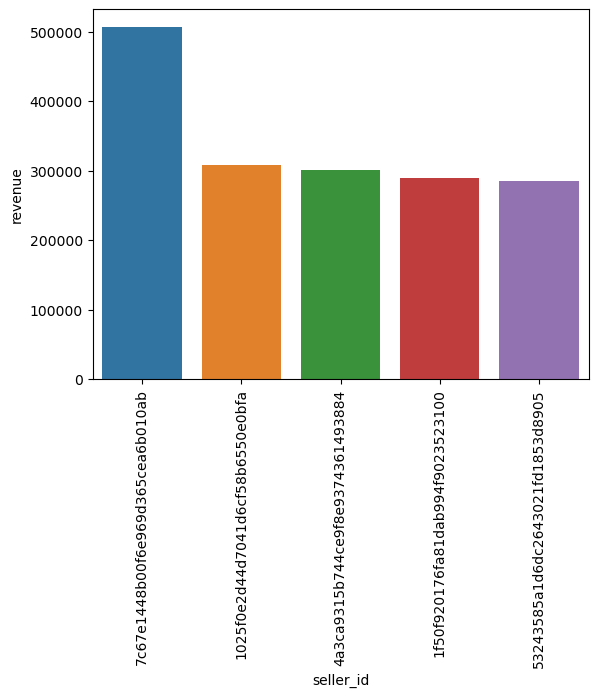

In [134]:
query = """ SELECT *, DENSE_RANK() OVER(ORDER BY revenue DESC) AS rn 
            FROM (SELECT 
                     order_items.seller_id, ROUND(SUM(payments.payment_value),2) revenue
                FROM
                     order_items
                    JOIN payments ON order_items.order_id = payments.order_id
                GROUP BY order_items.seller_id) as a ;
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
sns.barplot(x = "seller_id", y = "revenue", data = df.head() )
plt.xticks(rotation = 90)
plt.show()

# Advanced Queries

# 1. Calculate the moving average of order values for each customer over their order history.


In [110]:
query = """ SELECT customer_id, order_purchase_timestamp, payment,
    		avg(payment)
        	 over(partition by customer_id 
			   order by order_purchase_timestamp 
			   rows between 2 preceding and current row) as mov_avg
        FROM 
        (SELECT 
            orders.customer_id,
            orders.order_purchase_timestamp,
            payments.payment_value as payment
        FROM
            payments
                JOIN
            orders ON payments.order_id = orders.order_id) as a;
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id","order_purchase_timestamp","payment","mov_avg"])
df.head(10)


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# 2. Calculate the cumulative sales per month for each year.


In [113]:
query = """ SELECT years, months,payment, sum(payment)
            OVER(ORDER BY years, months) cumulative_sales FROM
                (SELECT YEAR(orders.order_purchase_timestamp) AS years,
                            MONTH(orders.order_purchase_timestamp) AS months,
                            ROUND(SUM(payments.payment_value), 2) AS payment
                FROM
                    orders
                        JOIN
                    payments ON orders.order_id = payments.order_id
                GROUP BY years , months
                ORDER BY years , months) as a;
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","months","payment","cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 3. Calculate the year-over-year growth rate of total sales.


In [122]:
query = """ with a as (SELECT  YEAR(orders.order_purchase_timestamp) AS years,
                	ROUND(SUM(payments.payment_value), 2) AS payment
            FROM
            	orders
            		JOIN
            	payments ON orders.order_id = payments.order_id
            GROUP BY years
            ORDER BY years) 

            select years, ((payment-lag(payment,1) over(order by years))/ 
                   lag(payment,1) over(order by years))*100 from a
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "YoY % growth"])
df

,years,YoY % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [130]:
query = """ WITH a AS (SELECT 
                customers.customer_id, MIN(orders.order_purchase_timestamp) first_order
            FROM
                customers
                    JOIN
                orders ON customers.customer_id = orders.customer_id
            GROUP BY customers.customer_id) ,
            
            b as (SELECT 
            	a.customer_id, count(distinct orders.order_purchase_timestamp)
            FROM a JOIN 
            	orders ON orders.customer_id = a.customer_id
                AND orders.order_purchase_timestamp > first_order 
                AND orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
            GROUP BY a.customer_id) 
            
            SELECT 100*(COUNT(DISTINCT a.customer_id)/count(DISTINCT b.customer_id)) 
            FROM a LEFT JOIN b 
            on a.customer_id = b.customer_id ;
        """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,None


# 5. Identify the top 3 customers who spent the most money in each year.

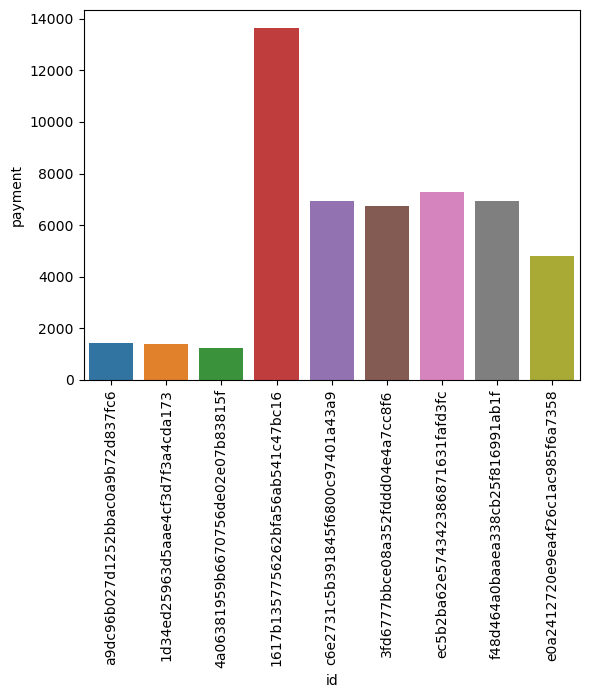

In [139]:
query = """ SELECT years, customer_id, payment, d_rank
            FROM 
            (SELECT 
                YEAR(orders.order_purchase_timestamp) years ,
                orders.customer_id,
                SUM(payments.payment_value) payment,
                DENSE_RANK() OVER(PARTITION BY YEAR(orders.order_purchase_timestamp) 
                ORDER BY SUM(payments.payment_value) DESC) d_rank
            FROM
                orders
                    JOIN
                payments ON payments.order_id = orders.order_id
            GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id ) as a
            WHERE d_rank <= 3 ;
        """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years", "id", "payment", "rank"])
sns.barplot(data = df,x = "id", y = "payment")
plt.xticks(rotation = 90)
plt.show()